In [ ]:
from google.colab import drive
import shutil
drive.mount("/content/drive")

In [ ]:
pip install ultralytics==8.0.196

In [ ]:
from ultralytics import YOLO

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vPTtZp7Wh7P8lRdRPdGe")
project = rf.workspace("cs-1430").project("wr-finder")
version = project.version(2)
dataset = version.download("yolov8")


### Fine Tuning

In [ ]:
# Load the model.
model = YOLO('yolov8n.pt')

# Training.
results = model.train(
   data='/content/WR-Finder-2/data.yaml',
   imgsz=640,
   epochs=10,
   batch=8,
   name='yolov8n_WR')

100%|██████████| 6.23M/6.23M [00:00<00:00, 23.1MB/s]
New https://pypi.org/project/ultralytics/8.2.7 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/WR-Finder-2/data.yaml, epochs=10, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_WR, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=F

In [ ]:
src = "/content/runs"
dst = "/content/drive/MyDrive/WR/runs"
shutil.move(src, dst)

'/content/drive/MyDrive/WR/runs'

### Load model directly from trained weights

In [ ]:
best_model = YOLO("/content/drive/MyDrive/WR/runs/detect/yolov8n_WR/weights/best.pt")

### Evaluate and Visualization

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
def non_max_suppression(boxes, scores, labels, threshold):
    # Initialize lists to store selected boxes and scores
    selected_boxes = []
    selected_scores = []
    selected_labels = []

    # Sort the boxes by their scores (in descending order)
    sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

    while len(sorted_indices) > 0:
        # Pick the box with the highest score
        i = sorted_indices[0]
        selected_boxes.append(boxes[i])
        selected_scores.append(scores[i])
        selected_labels.append(labels[i])

        # Calculate overlap with other boxes
        overlap = [calculate_overlap(boxes[i], boxes[j]) for j in sorted_indices[1:]]

        # Filter out boxes with overlap greater than the threshold
        filtered_indices = [j for j, o in zip(sorted_indices[1:], overlap) if o <= threshold]

        # Update sorted_indices to remove selected and redundant boxes
        sorted_indices = filtered_indices

    return selected_boxes, selected_scores, selected_labels

def calculate_overlap(box1, box2):
    # Calculate the intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate the union area
    area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = area1 + area2 - intersection_area

    # Calculate the overlap ratio
    overlap = intersection_area / union_area

    return overlap

In [ ]:
def plot_bounding_box(img, result, threshold=0.5):
  conf = result.boxes.conf.numpy()
  boxes = result.boxes.xyxy.numpy()
  labels = result.boxes.cls.numpy()
  selected_boxes, selected_scores, selected_labels = non_max_suppression(boxes, conf, labels, threshold)
  names = result.names
  for i in range(len(selected_boxes)):
    x1, y1, x2, y2 = selected_boxes[i]
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(img, names[labels[i]], (int(x1)-20, int(y1)-10), cv2.FONT_HERSHEY_PLAIN, 0.8, (0, 255, 0), 1)


0: 640x640 3 Corner Backs, 7 Linebackers, 2 Running Backs, 1 Safety, 1 Tight End, 4 Wide Receivers, 296.2ms
Speed: 3.0ms preprocess, 296.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


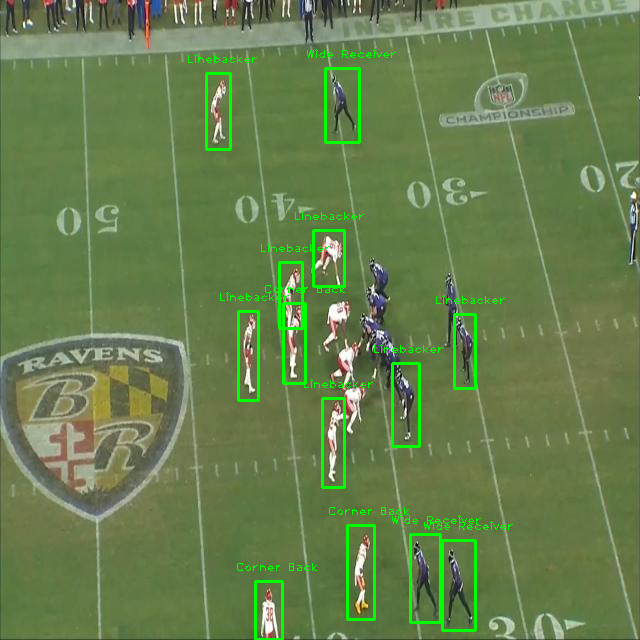

In [ ]:
img = cv2.imread("/content/drive/MyDrive/WR/NewWRData/test/images/AFCC103_png.rf.6c5fc19c43a9ffb71bae0ba33fdea648.jpg")
results = best_model.predict(img)
plot_bounding_box(img, results[0])
cv2_imshow(img)

In [ ]:
results[0].names

{0: 'Corner Back',
 1: 'Fullback',
 2: 'Linebacker',
 3: 'Quarterback',
 4: 'Running Back',
 5: 'Safety',
 6: 'Tight End',
 7: 'WRs',
 8: 'Wide Receiver'}